# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [ ]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"): 
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride    

        self.Conv2d1 = Conv2D(self.F1, kernel_size =(1, 1), strides = (self.stride,self.stride), 
                 kernel_initializer = glorot_uniform(seed=0))

        self.batch1 = BatchNormalization(axis = 3)
        self.batch2 = BatchNormalization(axis = 3)
        self.batch3 = BatchNormalization(axis = 3)
        self.batch4 = BatchNormalization(axis = 3)

        self.Conv2d2 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), strides = (1,1), padding = 'same', 
                 kernel_initializer = glorot_uniform(seed=0))

        self.Conv2d3 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))

        self.Conv2d4 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (self.stride,self.stride), padding = 'valid',
                        kernel_initializer = glorot_uniform(seed=0))                         


    def call(self, X,training=True):
   
      X_parallel = X

      X = self.Conv2d1(X)
      X = self.batch1(X)
      X = tf.nn.relu(X)


      X = self.Conv2d2(X)
      X = self.batch2(X)
      X = tf.nn.relu(X)



      X = self.Conv2d3(X)
      X = self.batch3(X)


      X_parallel = self.Conv2d4(X_parallel)
      X_parallel = self.batch4(X_parallel)

    
      X = Add()([X, X_parallel])
      X = tf.nn.relu(X)
      
      
      return X

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv1 = Conv2D(filters = self.F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))
        self.batch1 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)
      
        self.conv2 = Conv2D(filters = self.F2, kernel_size = (self.kernel, self.kernel), strides = (1,1), padding = 'same', 
                 kernel_initializer = glorot_uniform(seed=0))
        self.batch2 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)
    

        self.conv3 = Conv2D(filters = self.F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
                 kernel_initializer = glorot_uniform(seed=0))
        self.batch3 = BatchNormalization(axis = 3, momentum=0.99, epsilon=0.001)


    def call(self, X,training=True):
      X_parallel = X

      X = self.conv1(X)
      X = self.batch1(X)
      X = Activation('relu')(X)


      X = self.conv2(X)
      X = self.batch2(X)
      X = Activation('relu')(X)


      X = self.conv3(X)
      X = self.batch3(X)


      X = Add()([X, X_parallel])
      X = Activation('relu')(X)
      
      return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.avg = tf.keras.layers.GlobalAveragePooling2D()                                 
        self.batch = BatchNormalization() 
        self.convd1 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')
        self.conT = (Conv2DTranspose(filters = 32 ,kernel_size = (16,16), use_bias = False))
        
    def call(self, X):
      output = X
      gf = self.avg(output) 
      gf = tf.expand_dims(gf, axis=1)
      gf = tf.expand_dims(gf, axis=1)                 
      gf = self.batch(gf)
      gf = tf.nn.relu(gf)   
      gf = self.convd1(gf)
      gf = self.conT(gf)
      return gf

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        
        self.avg = AveragePooling2D((2, 2),  (2, 2), name = 'cf1_pool' )
        self.conv1 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')
        self.conv2 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same') 
        self.conv3 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')
        self.conv4 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')
        self.con_tra =  Conv2DTranspose(32 ,  (9, 9), use_bias = False )

    def call(self, X):
      # here X will a list of two elements 
      INP, FLOW = X[0], X[1] 
      Concat = Concatenate()([INP,FLOW])
      cf = self.avg(Concat) 
      cf_1 = self.conv1(cf)
      cf_2 = self.conv2(cf_1) 
      cf_3 = self.conv3(cf_2)
      cf_A = Activation('relu')(cf_3)
      cf_4 = self.conv4(cf_A)
      cf_A1 = Activation('sigmoid')(cf_4)
      cf_M = Multiply()([cf_2 , cf_A1])
      cf_add = Add()([cf_2,cf_M])
      cf_Tr = self.con_tra(cf_add)
  


        # implement the context flow as mentioned in the above cell
      return cf_Tr

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')
        self.avg = GlobalAveragePooling2D() 
        self.conv2 = Conv2D(filters = 32, kernel_size = (1, 1), activation = 'relu', padding = 'same')
        self.batch = BatchNormalization()
        self.up =  UpSampling2D( interpolation='bilinear')
    def call(self, X,training=True):
      FSM_1 = self.conv1(X)
      FSM_avg = self.avg(FSM_1) 
      FSM_avg = tf.expand_dims(FSM_avg, axis=1)
      FSM_avg = tf.expand_dims(FSM_avg, axis=1) 
      FSM = self.conv2(FSM_avg)
      FSM_bn = self.batch(FSM)
      FSM_s = Activation('sigmoid')(FSM_bn)
      FSM_T = Multiply()([FSM_1,FSM_s])
      FSM_T  = self.up(FSM_T)
      
      # implement the FSM modules based on image in the above cells
      return FSM_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.up =  UpSampling2D((2,2), interpolation='bilinear')
        self.conv1 = Conv2D(filters = 32, kernel_size = (7, 1), activation = 'relu', padding = 'same')
        self.conv2 = Conv2D(filters = 32, kernel_size = (1, 7), activation = 'relu', padding = 'same')

        self.conv3 = Conv2D(filters = 32, kernel_size = (1, 7), activation = 'relu', padding = 'same')
        self.conv4 = Conv2D(filters = 32, kernel_size = (7, 1), activation = 'relu', padding = 'same')

        self.conv5 = Conv2D(filters = 32, kernel_size =(3, 3), activation = 'relu', padding = 'same')
        self.up1 = UpSampling2D((2,2), interpolation='bilinear')
   
        self.conv6 = Conv2D(filters = 21, kernel_size = (3, 3), activation = 'relu', padding = 'same')
        self.conv7 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')
    
        self.up2  = UpSampling2D((4,4), interpolation = 'bilinear')
        
        
    def call(self, X,training=True):
      fsm, X_Stage_2_ = X[0], X[1]

      fsm =  self.conv7(fsm)

      ag_L1 = self.conv1(X_Stage_2_)
      ag_L2 = self.conv2(ag_L1)

      ag_L3 = self.conv3(X_Stage_2_)
      ag_L4 = self.conv4(ag_L3)

      sum1 = Add()([ag_L2,ag_L4])

      ag_conv = self.conv5(sum1)

      sum2 = Add()([sum1,ag_conv])


      
      sum2 = self.up1(sum2)
      CF = concatenate([fsm,sum2])
      X = self.conv6(CF)
    
      X  = self.up2(X)
      X = (Activation('softmax'))(X)
        # please implement the above mentioned architecture
      return X

In [ ]:
X_input = Input(shape=(128,128,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)


print(X.shape)

(None, 64, 64, 64)


In [ ]:
# Stage 2
convol1 = convolutional_block(kernel=3, filters=[4, 4, 8], stride=4,name = 'block_conv1' )
identity1 = identity_block( kernel = 3, filters = [4, 4, 8],name = 'identity1')
identity2 = identity_block( kernel = 3, filters = [4, 4, 8],name = 'identity2')
X_Stage_2_ = convol1(X)
X_Stage_2 = identity1(X_Stage_2_)
X_Stage_2 = identity2(X_Stage_2)


# Stage 3 
convol2 = convolutional_block(kernel=3, filters=[8, 8, 16], stride=1,name = 'block_conv2')
identity3 = identity_block( kernel = 3, filters = [8, 8, 16],name = 'identity3')
identity4 = identity_block( kernel = 3, filters = [8, 8, 16],name = 'identity4')
identity5 = identity_block( kernel = 3, filters = [8, 8, 16],name = 'identity5')
X_Stage_3 = convol2(X_Stage_2)
X_Stage_3 = identity3(X_Stage_3)
X_Stage_3 = identity4(X_Stage_3)
X_Stage_3 = identity5(X_Stage_3)

# Stage 4 
convol3 = convolutional_block(kernel=3, filters=[16, 16, 32], stride=1,name = 'block_conv3')
identity6 = identity_block( kernel = 3, filters = [16, 16, 32],name = 'identity6')
identity7 = identity_block( kernel = 3, filters = [16, 16, 32],name = 'identity7')
identity8 = identity_block( kernel = 3, filters = [16, 16, 32],name = 'identity8')
identity9 = identity_block( kernel = 3, filters = [16, 16, 32],name = 'identity9')
identity10 = identity_block( kernel = 3, filters = [16, 16, 32],name = 'identity10')
X_Stage_4 = convol3(X_Stage_3)
X_Stage_4 = identity6(X_Stage_4)
X_Stage_4 = identity7(X_Stage_4)
X_Stage_4 = identity8(X_Stage_4)
X_Stage_4 = identity9(X_Stage_4)
X_Stage_4 = identity10(X_Stage_4)

# Stage 5 
convol4 = convolutional_block(kernel=3, filters=[32, 32, 64], stride=1,name = 'block_conv4')
identity11 = identity_block( kernel = 3, filters = [32, 32, 64],name = 'identity11')
identity12 = identity_block( kernel = 3, filters = [32, 32, 64],name = 'identity12')
X_Stage_5 = convol4(X_Stage_4)
X_Stage_5 = identity11(X_Stage_5)
X_Stage_5 = identity12(X_Stage_5)

#global flow
glo = global_flow()
gf = glo(X_Stage_5)

#Context flow
context2 = context_flow(name = 'cf1_pool2')
context3 = context_flow(name = 'cf1_pool3')
context4 = context_flow(name = 'cf1_pool4')

X1 = [X_Stage_5,gf]
cf_1 = context2(X1)

X1 = [X_Stage_5,cf_1]
cf_2 = context3(X1)

X1 = [X_Stage_5,cf_2]
cf_3 = context4(X1)

#adding 
sum = Add(name = 'add')([gf, cf_1, cf_2, cf_3])

#feature selection module
feature = fsm()
FSM_T = feature(sum)


#Adapted Global Convolutional Network
Adapted = agcn()
X2 = [FSM_T, X_Stage_2_]

output = Adapted(X2)

model = Model(inputs = X_input, outputs = output)

for layer in model.layers:
  layer.trainable = True 

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           bn_conv1[0][0]                   
____________________________________________________________________________________________

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [ ]:
rms = tf.keras.optimizers.RMSprop(learning_rate=0.001)
focal_loss = sm.losses.cce_dice_loss
model.compile(rms, focal_loss, metrics=[iou_score])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="model_save/model.{epoch:02d}-{val_iou_score:.2f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_iou_score', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader)//5, epochs=50,\
                              validation_data=test_dataloader,validation_steps =len(test_dataloader)//5)  

Epoch 1/50
136/136 [==============================] - 1291s 9s/step - loss: 1.0437 - iou_score: 0.0410 - val_loss: 0.9544 - val_iou_score: 0.0715
Epoch 2/50
136/136 [==============================] - 943s 7s/step - loss: 0.9008 - iou_score: 0.1160 - val_loss: 0.8875 - val_iou_score: 0.1158
Epoch 3/50
136/136 [==============================] - 893s 7s/step - loss: 0.8532 - iou_score: 0.1519 - val_loss: 0.8409 - val_iou_score: 0.1523
Epoch 4/50
136/136 [==============================] - 725s 5s/step - loss: 0.8319 - iou_score: 0.1701 - val_loss: 0.8175 - val_iou_score: 0.1673
Epoch 5/50
136/136 [==============================] - 675s 5s/step - loss: 0.8164 - iou_score: 0.1796 - val_loss: 0.7900 - val_iou_score: 0.1867
Epoch 6/50
136/136 [==============================] - 631s 5s/step - loss: 0.8009 - iou_score: 0.1893 - val_loss: 0.7643 - val_iou_score: 0.2059
Epoch 7/50
136/136 [==============================] - 543s 4s/step - loss: 0.7838 - iou_score: 0.2043 - val_loss: 0.7498 - val_io

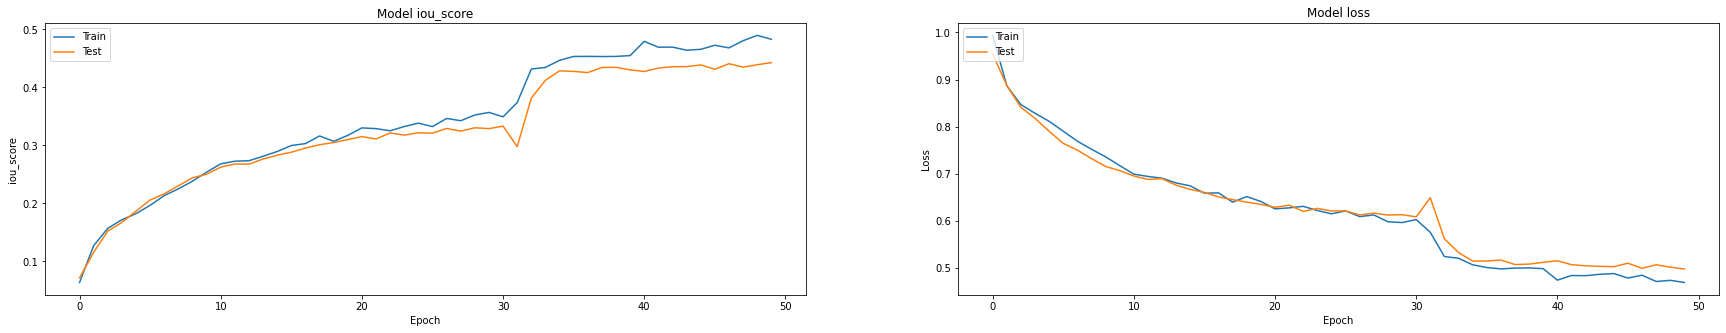

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

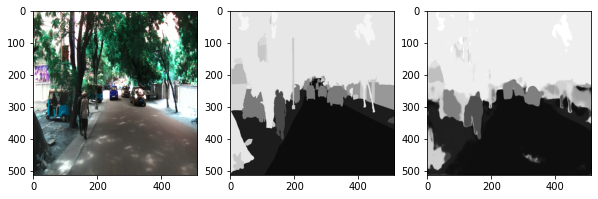

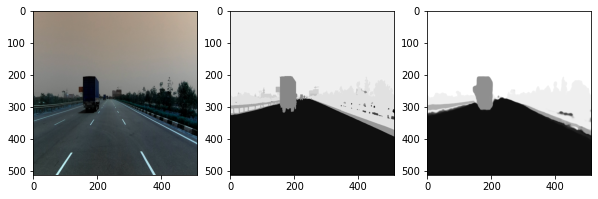

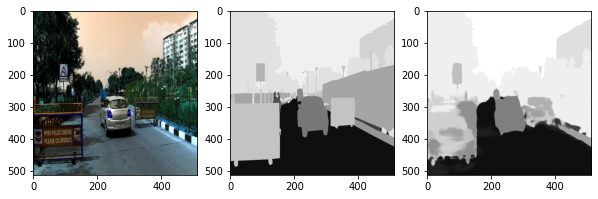

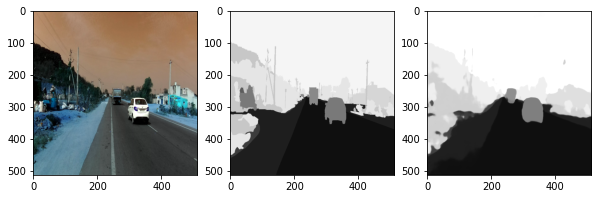

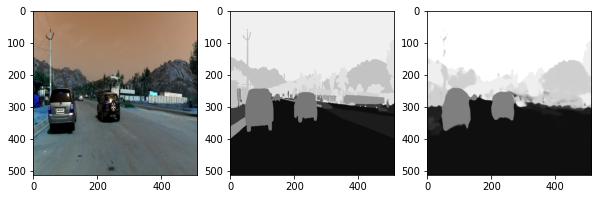

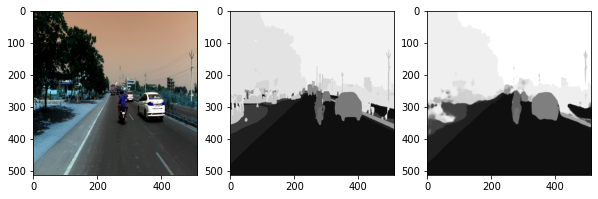

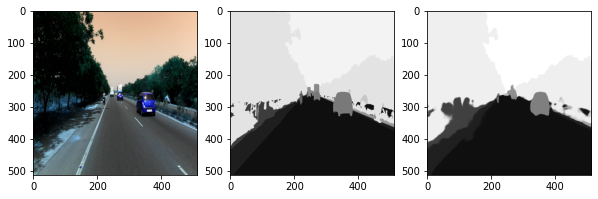

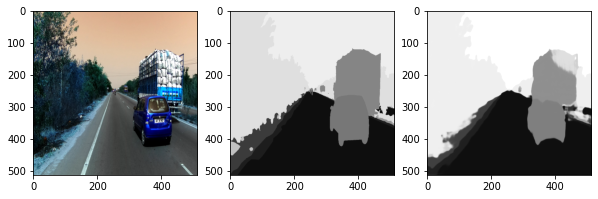

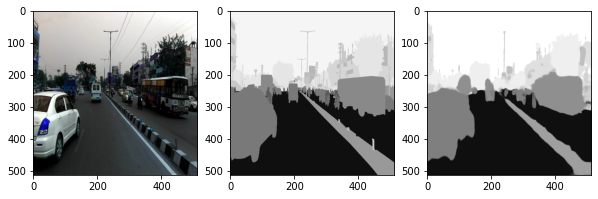

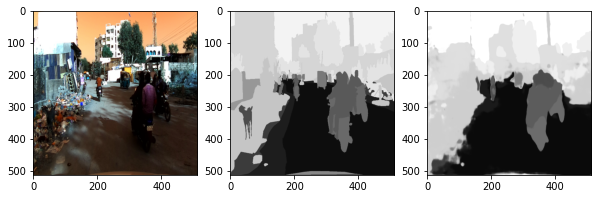

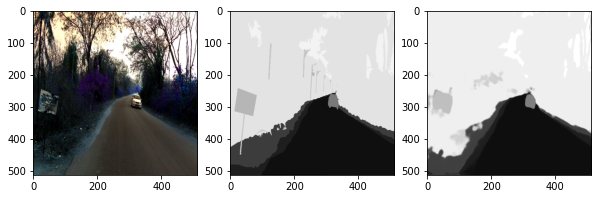

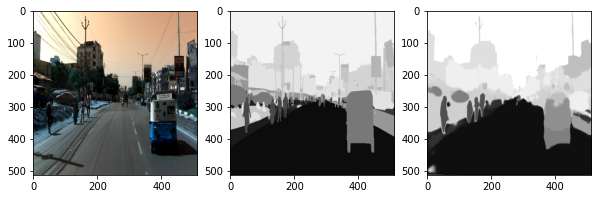

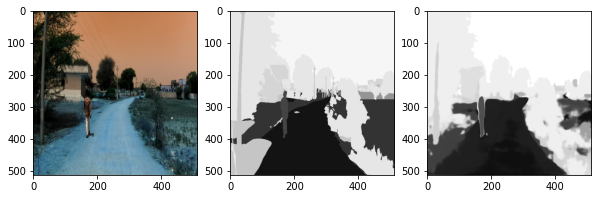

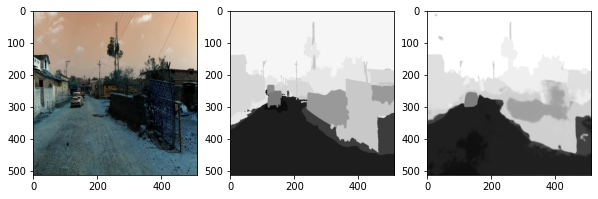

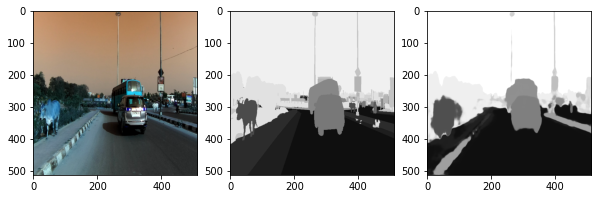

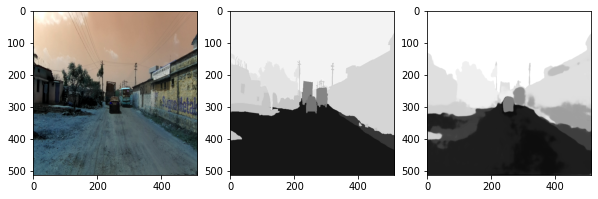

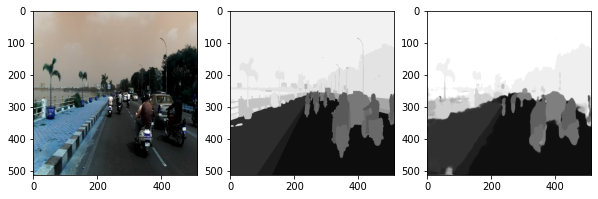

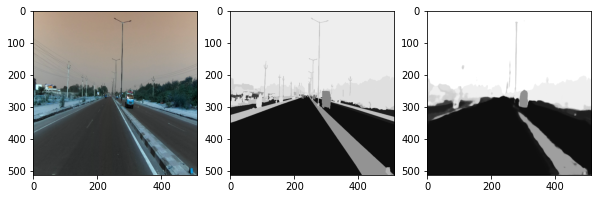

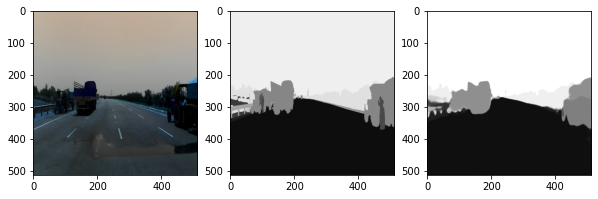

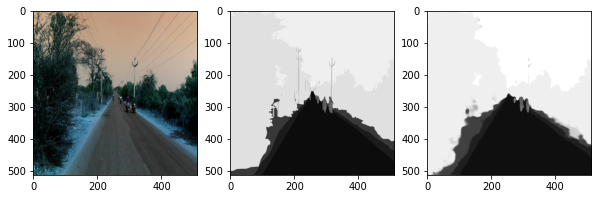

In [ ]:
a = X_test
for i in range(20):  
    #original image
    image = cv2.imread(a[i][0],cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512, 512))
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    predict = np.array([predicted[0,:,:,i]*j for i , j in enumerate(class_label)])
    predict = sum(predict)
    
    #original segmentation map
    image_mask = cv2.imread(a[i][1], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray')
    plt.subplot(133)
    plt.imshow(predict, cmap='gray')
    plt.show()

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations